# HELIOS Demo
This notebook demonstrates the basic usage of the HELIOS simulation package.

In [1]:
import sys
sys.path.insert(0, '../src')
import helios
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

## 1. Define the Scene
We start by creating a scene with a star and a planet. The distance to the system is defined at the Scene level.

In [2]:
scene = helios.components.Scene(distance=10*u.pc)

# Star at the center
star = helios.components.Star(temperature=5700*u.K, magnitude=5, mass=1*u.M_sun, position=(0*u.AU, 0*u.AU))

# Planet at 1 AU
planet = helios.components.Planet(mass=1*u.M_jup, position=(1*u.AU, 0*u.AU))

scene.add(star)
scene.add(planet)
# Add zodiacal and exozodiacal light components
zodi = helios.components.Zodiacal(brightness=0.5)
exozodi = helios.components.ExoZodiacal(brightness=0.3)
scene.add(zodi)
scene.add(exozodi)
print(f"Scene created with {len(scene.objects)} objects.")

Scene created with 4 objects.


### Visualize the Scene
We can visualize the scene geometry.

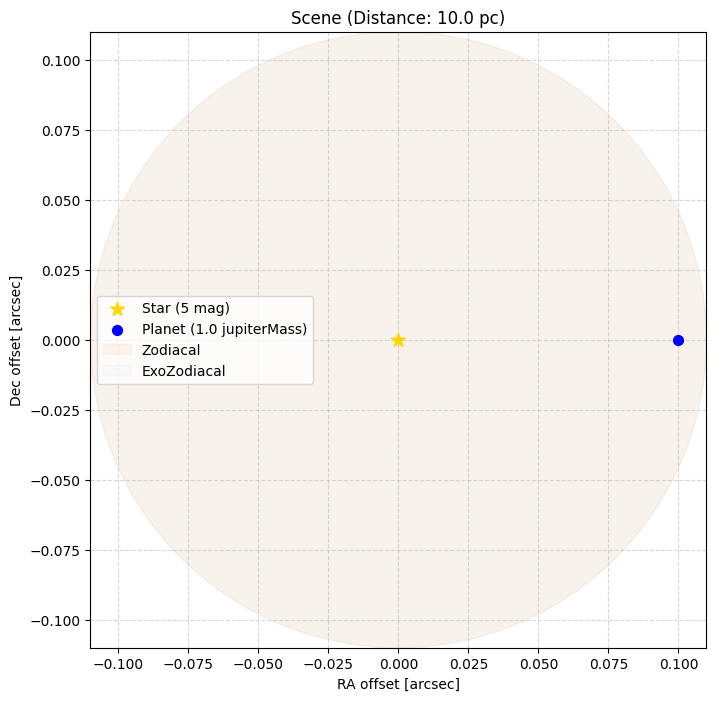

In [3]:
scene.plot()
plt.show()

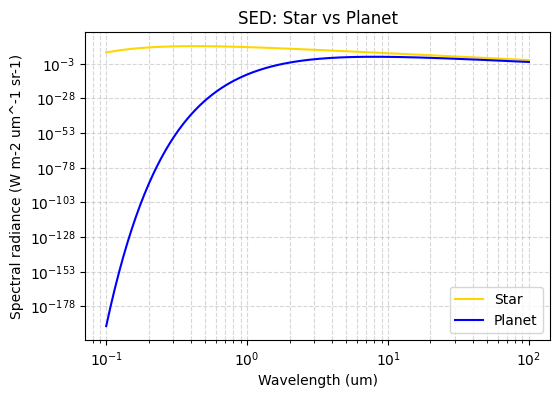

In [4]:
# Plot SEDs for star and planet using the new helper
ax = star.plot_sed(color='gold', label='Star')
ax = planet.plot_sed(ax=ax, color='blue', label='Planet')
ax.set_title('SED: Star vs Planet')
plt.show()

## 2. Define Optics and Detectors
Next, we define the telescope and camera.

In [5]:
collectors = helios.components.Collectors(latitude=0*u.deg, longitude=0*u.deg, altitude=2400*u.m)
pupil = helios.components.Pupil(8*u.m)
collectors.add(size=8*u.m, shape=pupil, position=(0,0))

camera = helios.components.Camera(pixels=(256, 256))

context = helios.Context()
context.add_layer(scene)
context.add_layer(collectors)
context.add_layer(camera)

## Pupil Construction Demo
This cell shows how to construct a pupil by hand and how to obtain a preset (JWST).
You can retrieve the final pupil as a NumPy array with `get_array(...)` and display it with `plot(...)`.

Manual pupil array shape: (256, 256) min/max: 0.0 1.0


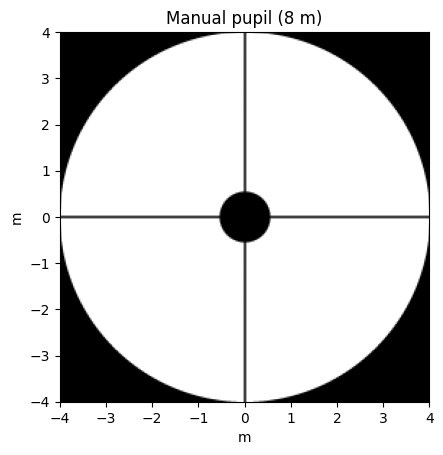

JWST pupil array shape: (512, 512)


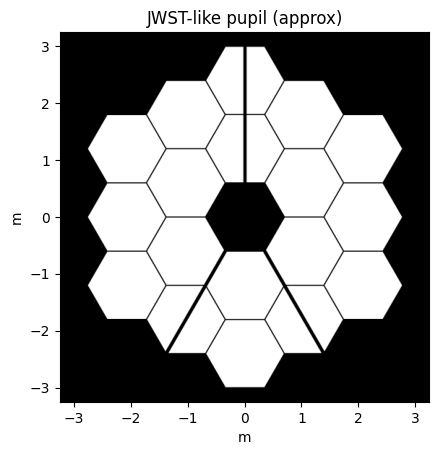

In [6]:
# Manual pupil: simple 8-m class pupil with 4 spiders and central obscuration
p_manual = helios.components.Pupil(8*u.m)
p_manual.add_disk(radius=4.0)
p_manual.add_central_obscuration(diameter=1.1)
p_manual.add_spiders(arms=4, width=0.05)
arr_manual = p_manual.get_array(npix=256, soft=True)
print('Manual pupil array shape:', arr_manual.shape, 'min/max:', arr_manual.min(), arr_manual.max())
ax = p_manual.plot(npix=256)
ax.set_title('Manual pupil (8 m)')
plt.show()

# JWST preset pupil (via Pupil.like)
p_jwst = helios.components.Pupil.like('JWST')
arr_jwst = p_jwst.get_array(npix=512, soft=True)
print('JWST pupil array shape:', arr_jwst.shape)
ax = p_jwst.plot(npix=512)
ax.set_title('JWST-like pupil (approx)')
plt.show()

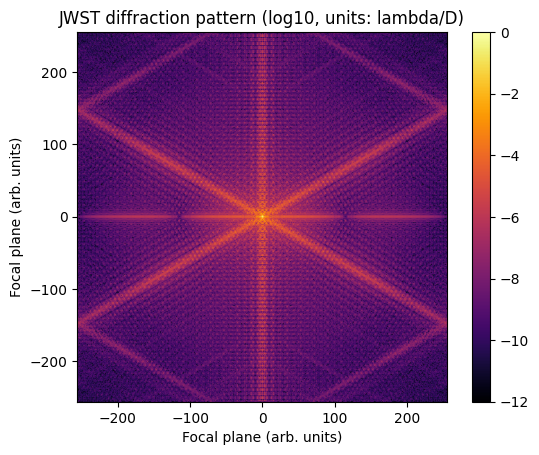

In [7]:
# Diffraction pattern demo for JWST preset
p_jwst = helios.components.Pupil.like('JWST')
# show diffraction pattern in log scale (units: lambda/D)
ax = p_jwst.plot_diffraction_pattern(npix=512, log=True, cmap='inferno', wavelength=550e-9)
ax.set_title('JWST diffraction pattern (log10, units: lambda/D)')
plt.show()

### Image formation demo
Render the `Scene` to an image and propagate it through the pupil to obtain the instrument image.

Scene render shape, min/max: (256, 256) 0.04927866464995703 1.0


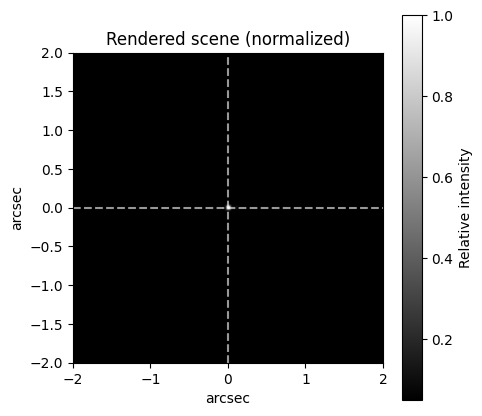

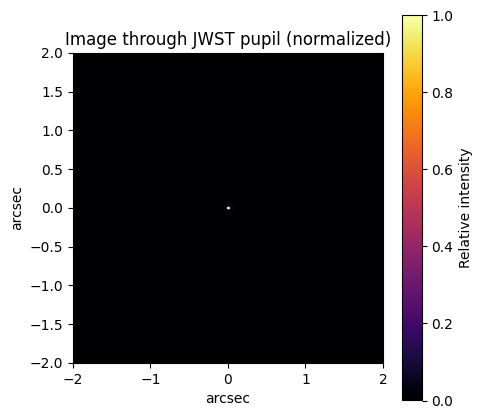

In [8]:
# Render the scene (in arcsec) to a small image and form the instrument image through the JWST pupil
scene_img, x, y = scene.render(npix=256, fov=4*u.arcsec, return_coords=True)
print('Scene render shape, min/max:', scene_img.shape, scene_img.min(), scene_img.max())
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
extent = [x[0].value, x[-1].value, y[0].value, y[-1].value]
im0 = ax.imshow(scene_img, origin='lower', cmap='gray', extent=extent, aspect='equal')
ax.set_title('Rendered scene (normalized)')
ax.set_xlabel('arcsec')
ax.set_ylabel('arcsec')
ax.axvline(0.0, color='white', ls='--', alpha=0.6)
ax.axhline(0.0, color='white', ls='--', alpha=0.6)
plt.colorbar(im0, ax=ax, label='Relative intensity')
plt.show()
# propagate through pupil
p_jwst = helios.components.Pupil.like('JWST')
img = p_jwst.image_through_pupil(scene_img, soft=True)
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
im1 = ax.imshow(img, origin='lower', cmap='inferno', extent=extent, aspect='equal')
ax.set_title('Image through JWST pupil (normalized)')
ax.set_xlabel('arcsec')
ax.set_ylabel('arcsec')
plt.colorbar(im1, ax=ax, label='Relative intensity')
plt.show()

## 3. Run Simulation
Finally, we run the simulation.

In [9]:
result = context.observe()
print("Simulation complete. Result shape:", result.shape)

Simulation complete. Result shape: (256, 256)
